In [1]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from src.models.layers import *
from src.common.optimizer import SGD
from src.common.trainer import RnnlmTrainer
from src.common.util import eval_perplexity
from src.data import jjt

In [2]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()
        

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [3]:
# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = jjt.load_data()
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print(f'corpus size: {corpus_size}, vocabulary size: {vocab_size}')

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチ各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        # 勾配を求め、パラメータの更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch {} | perplexity {:.2f}'.format(epoch+1, ppl))
    total_loss, loss_count = 0, 0

corpus size: 1000, vocabulary size: 413
| epoch 1 | perplexity 315.88
| epoch 2 | perplexity 181.26
| epoch 3 | perplexity 160.33
| epoch 4 | perplexity 151.51
| epoch 5 | perplexity 146.30
| epoch 6 | perplexity 138.38
| epoch 7 | perplexity 131.23
| epoch 8 | perplexity 119.92
| epoch 9 | perplexity 112.83
| epoch 10 | perplexity 107.05
| epoch 11 | perplexity 101.77
| epoch 12 | perplexity 98.19
| epoch 13 | perplexity 92.79
| epoch 14 | perplexity 92.94
| epoch 15 | perplexity 88.52
| epoch 16 | perplexity 84.17
| epoch 17 | perplexity 81.36
| epoch 18 | perplexity 78.32
| epoch 19 | perplexity 74.00
| epoch 20 | perplexity 73.79
| epoch 21 | perplexity 71.07
| epoch 22 | perplexity 66.86
| epoch 23 | perplexity 65.77
| epoch 24 | perplexity 62.13
| epoch 25 | perplexity 59.52
| epoch 26 | perplexity 57.44
| epoch 27 | perplexity 56.06
| epoch 28 | perplexity 52.85
| epoch 29 | perplexity 50.55
| epoch 30 | perplexity 49.38
| epoch 31 | perplexity 46.83
| epoch 32 | perplexity 46.1

| epoch 1 |  iter 1 / 95 | time 0[s] | perplexity 2475.38
| epoch 1 |  iter 21 / 95 | time 0[s] | perplexity 461.56
| epoch 1 |  iter 41 / 95 | time 0[s] | perplexity 215.48
| epoch 1 |  iter 61 / 95 | time 0[s] | perplexity 179.17
| epoch 1 |  iter 81 / 95 | time 1[s] | perplexity 136.58
| epoch 2 |  iter 1 / 95 | time 1[s] | perplexity 128.84
| epoch 2 |  iter 21 / 95 | time 1[s] | perplexity 112.76
| epoch 2 |  iter 41 / 95 | time 1[s] | perplexity 83.62
| epoch 2 |  iter 61 / 95 | time 1[s] | perplexity 87.63
| epoch 2 |  iter 81 / 95 | time 2[s] | perplexity 69.47
| epoch 3 |  iter 1 / 95 | time 2[s] | perplexity 65.78
| epoch 3 |  iter 21 / 95 | time 2[s] | perplexity 63.20
| epoch 3 |  iter 41 / 95 | time 2[s] | perplexity 47.88
| epoch 3 |  iter 61 / 95 | time 3[s] | perplexity 50.44
| epoch 3 |  iter 81 / 95 | time 3[s] | perplexity 40.90
| epoch 4 |  iter 1 / 95 | time 3[s] | perplexity 42.90
| epoch 4 |  iter 21 / 95 | time 3[s] | perplexity 39.14
| epoch 4 |  iter 41 / 95 |

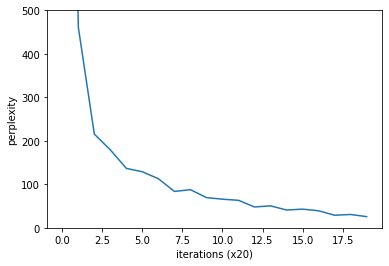

evaluating perplexity ...
5 / 6
test perprexity: 161.9536166423878


In [4]:
# RNNLMの実行

wordvec_size = 100
hidden_size = 100
time_size = 10
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = jjt.load_data('train')
corpus_test, _, _ = jjt.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print(f'test perprexity: {ppl_test}')

# パラメータの保存
model.save_params()